In [27]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
from tqdm import tqdm
from triangle import triangulate
from utils import (
    get_middle_indices,
    fill_stiffness_matrix,
)
from matplotlib import cm

dill.settings["recurse"] = True

### Get precomputed integrals

In [28]:
biharmonic_functional = dill.load(
    open("../calculations/argyris_quintic_biharmonic_matrix_with_mixed_simplified", "rb")
)
basis_integral_values = dill.load(
    open("../calculations/argyris_quintic_biharmonic_matrix_right_values_simplified", "rb")
)

### Initialize the domain

In [29]:
t = np.linspace(0, 1, 50, endpoint=False)
points = np.stack((np.cos(2 * np.pi*t), np.sin(2 * np.pi*t))).T

seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

### Run triangulation

In [30]:
cndt = triangulate({"vertices": points, "segments": seg}, opts="pq30a0.01neo2s")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
edges = cndt["edges"]
vertex_marker_is_boundary = cndt["vertex_markers"]
edge_marker_is_boundary = cndt["edge_markers"]
print(
    f"Total number of points:\t\t{points.shape[0]}\nTotal number of elements:\t{triangles.shape[0]}"
)

Total number of points:		1019
Total number of elements:	484


### Separate middles

In [31]:
is_middle = get_middle_indices(points.shape[0], triangles)

### Visualize triangulation

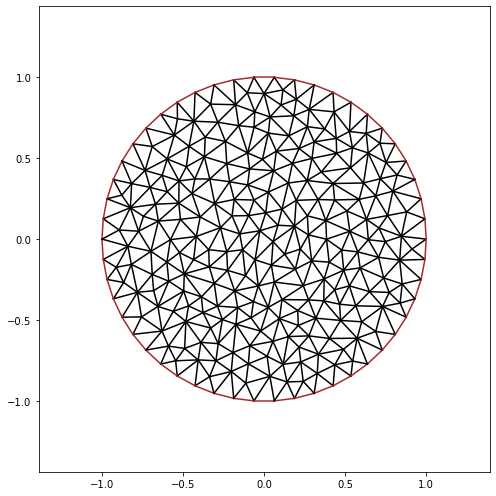

In [32]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")

cl = ["black", "brown"]

for eidx, edge in enumerate(edges):
    ax.plot(
        points[edge][:, 0],
        points[edge][:, 1],
        color=cl[edge_marker_is_boundary[eidx][0]],
    )

ax.set_xlim([points[:, 0].min() - 1 / 2, points[:, 0].max() + 1 / 2])
ax.set_ylim([points[:, 1].min() - 1 / 2, points[:, 1].max() + 1 / 2])

fig.tight_layout()
plt.tight_layout()

plt.show()

### Initialize variables

In [33]:
total_points = points.shape[0]
num_midpoints = is_middle.sum()
num_nodes = total_points - num_midpoints
NUM = 6 * num_nodes + num_midpoints

In [34]:
x, y = sympy.symbols("x y", real=True)

### Define the right part of the equation

In [35]:
F = sympy.Float(1)
F_x = F.diff(x)
F_y = F.diff(y)
F_xx = F_x.diff(x)
F_xy = F_x.diff(y)
F_yy = F_y.diff(y)

In [36]:
right_part_values = np.zeros((total_points, 6))
right_part_values[:, 0] = sympy.lambdify((x, y), F)(*points.T)
right_part_values[:, 1] = sympy.lambdify((x, y), F_x)(*points.T)
right_part_values[:, 2] = sympy.lambdify((x, y), F_y)(*points.T)
right_part_values[:, 3] = sympy.lambdify((x, y), F_xx)(*points.T)
right_part_values[:, 4] = sympy.lambdify((x, y), F_xy)(*points.T)
right_part_values[:, 5] = sympy.lambdify((x, y), F_yy)(*points.T)

### Stiffnes matrix assembling

In [37]:
def orient_batch(arg):
    indices = np.argsort(arg[:, :3], axis=-1)
    vertices = np.take_along_axis(arg[:, :3], indices, axis=-1)
    middle_points = np.take_along_axis(arg[:, 3:], indices, axis=-1)
    oriented = np.concatenate([vertices, middle_points], axis=-1)

    return oriented

In [38]:
triangles = orient_batch(triangles)
pts = points[triangles[:, :3]]

In [39]:
x1 = right_part_values[triangles[:, 0]]
x2 = right_part_values[triangles[:, 1]]
x3 = right_part_values[triangles[:, 2]]

In [40]:
n1 = right_part_values[triangles[:, 3], 1:3]
n2 = right_part_values[triangles[:, 4], 1:3]
n3 = right_part_values[triangles[:, 5], 1:3]

In [41]:
bilinear_form_ = biharmonic_functional(
    pts[:, 0, 0], pts[:, 0, 1],
    pts[:, 1, 0], pts[:, 1, 1],
    pts[:, 2, 0], pts[:, 2, 1]
).transpose(2, 0, 1)

right_part_ = basis_integral_values(
    pts[:, 0, 0], pts[:, 0, 1],
    pts[:, 1, 0], pts[:, 1, 1],
    pts[:, 2, 0], pts[:, 2, 1], 
    *x1.T, *x2.T, *x3.T, *n1.T, *n1.T, *n3.T
)[:, 0].T

matrix = np.zeros((NUM, NUM), dtype=np.float32)
b = np.zeros((NUM), dtype=np.float32)

for bilinear_form, right_part, element in tqdm(zip(bilinear_form_, right_part_, triangles), total=len(triangles)):

    fill_stiffness_matrix(
        matrix,
        b,
        bilinear_form,
        right_part,
        element,
        vertex_marker_is_boundary,
        num_nodes,
    )

100%|██████████| 484/484 [00:02<00:00, 162.56it/s]


### Visualize stiffness matrix

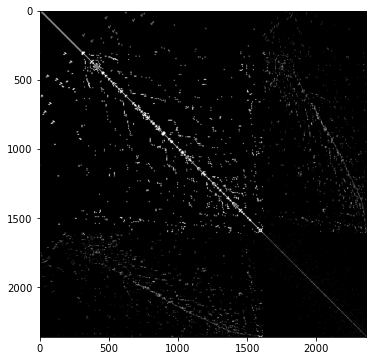

In [42]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(matrix != 0, cmap="gray")
plt.show()

### Solve the system

In [43]:
c = np.linalg.solve(matrix, b)

### Get values

In [44]:
U = (1 - x**2 - y**2)**2 / 64
U_x = sympy.lambdify((x, y), U.diff(x))(*points.T[:, :num_nodes])
U_y = sympy.lambdify((x, y), U.diff(y))(*points.T[:, :num_nodes])
U_xx = sympy.lambdify((x, y), U.diff(x, x))(*points.T[:, :num_nodes])
U_xy = sympy.lambdify((x, y), U.diff(x, y))(*points.T[:, :num_nodes])
U_yy = sympy.lambdify((x, y), U.diff(y, y))(*points.T[:, :num_nodes])
U = sympy.lambdify((x, y), U)(*points.T[:, :num_nodes])
_x_ = points[:num_nodes, 0]
_y_ = points[:num_nodes, 1]
F = c[0 : (6 * num_nodes) : 6]
Fx = c[1 : (6 * num_nodes) : 6]
Fy = c[2 : (6 * num_nodes) : 6]
Fxx = c[3 : (6 * num_nodes) : 6]
Fxy = c[4 : (6 * num_nodes) : 6]
Fyy = c[5 : (6 * num_nodes) : 6]

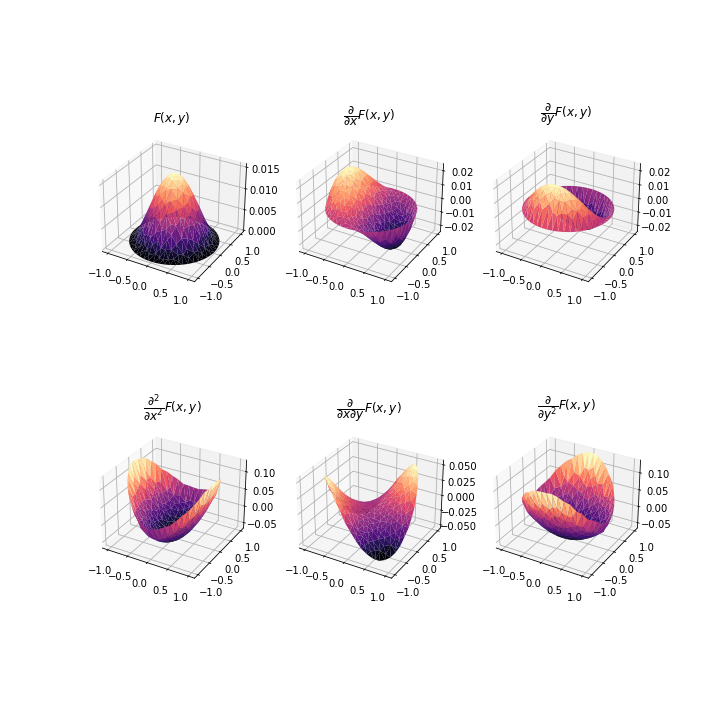

In [45]:
%matplotlib widget
fig, ax = plt.subplots(2, 3, figsize=(10, 10), subplot_kw=dict(projection="3d"))
plot_1 = ax[0, 0].plot_trisurf(_x_, _y_, F, triangles=triangles[:, :3], cmap=cm.magma)
ax[0, 0].set_title(r"$F\left(x, y\right)$")
plot_2 = ax[0, 1].plot_trisurf(_x_, _y_, Fx, triangles=triangles[:, :3], cmap=cm.magma)
ax[0, 1].set_title(r"$\dfrac{\partial}{\partial x}F\left(x, y\right)$")
plot_3 = ax[0, 2].plot_trisurf(_x_, _y_, Fy, triangles=triangles[:, :3], cmap=cm.magma)
ax[0, 2].set_title(r"$\dfrac{\partial}{\partial y}F\left(x, y\right)$")
plot_4 = ax[1, 0].plot_trisurf(_x_, _y_, Fxx, triangles=triangles[:, :3], cmap=cm.magma)
ax[1, 0].set_title(r"$\dfrac{\partial^{2}}{\partial x^{2}}F\left(x, y\right)$")
plot_5 = ax[1, 1].plot_trisurf(_x_, _y_, Fxy, triangles=triangles[:, :3], cmap=cm.magma)
ax[1, 1].set_title(r"$\dfrac{\partial}{\partial x \partial y}F\left(x, y\right)$")
plot_6 = ax[1, 2].plot_trisurf(_x_, _y_, Fyy, triangles=triangles[:, :3], cmap=cm.magma)
ax[1, 2].set_title(r"$\dfrac{\partial}{\partial y^{2}}F\left(x, y\right)$")
plt.show()

### Error

### $ \lVert F - \hat{F} \rVert_{\infty}$

In [46]:
abs(U - F).max()

4.378433281214747e-05

### $ \lVert F_{x} - \hat{F}_{x} \rVert_{\infty}$

In [47]:
abs(U_x - Fx).max()

8.75943461850371e-05

### $ \lVert F_{y} - \hat{F}_{y} \rVert_{\infty}$

In [48]:
abs(U_y - Fy).max()

8.939816725448899e-05

### $ \lVert F_{xx} - \hat{F}_{xx} \rVert_{\infty}$

In [49]:
abs(U_xx - Fxx).max()

0.023432684821889344

### $ \lVert F_{xy} - \hat{F}_{xy} \rVert_{\infty}$

In [50]:
abs(U_xy - Fxy).max()

0.009963451333684148

### $ \lVert F_{yy} - \hat{F}_{yy} \rVert_{\infty}$

In [51]:
abs(U_yy - Fyy).max()

0.02310180832944357